This code was used in colab in the browser

In [ ]:
# connect to my google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# generate data augmentation

import os
import shutil
from PIL import Image, ImageOps, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = (224, 224)
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/subimages_for_modeling'  # Path to the original dataset
AUGMENTED_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_all'
NUM_AUGMENTATIONS = 5  # Number of augmentations per image

# Clean up any previous augmented data
if os.path.exists(AUGMENTED_DATASET_PATH):
    shutil.rmtree(AUGMENTED_DATASET_PATH)
os.makedirs(AUGMENTED_DATASET_PATH)

# Augmentation functions
def random_rotation(image):
    return image.rotate(np.random.uniform(-30, 30))

def random_flip(image):
    if np.random.rand() > 0.5:
        return ImageOps.mirror(image)
    return image

def random_shift(image):
    max_dx = 0.2 * image.size[0]
    max_dy = 0.2 * image.size[1]
    dx = np.random.uniform(-max_dx, max_dx)
    dy = np.random.uniform(-max_dy, max_dy)
    return image.transform(image.size, Image.AFFINE, (1, 0, dx, 0, 1, dy))

def random_zoom(image):
    scale = np.random.uniform(0.8, 1.2)
    w, h = image.size
    x = int(np.random.uniform(0, w*(1-scale)))
    y = int(np.random.uniform(0, h*(1-scale)))
    image = image.crop((x, y, x + int(w*scale), y + int(h*scale)))
    return image.resize(IMG_SIZE, Image.LANCZOS)

def augment_image(image):
    image = random_rotation(image)
    image = random_flip(image)
    image = random_shift(image)
    image = random_zoom(image)
    return image

# Function to augment and save images
def augment_and_save_images(source_dir, dest_dir):
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            dest_class_path = os.path.join(dest_dir, class_name)
            os.makedirs(dest_class_path, exist_ok=True)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    image = Image.open(img_path)
                except (UnidentifiedImageError, IsADirectoryError):
                    print(f"Skipping file {img_path} as it is not a valid image.")
                    continue
                for i in range(NUM_AUGMENTATIONS):
                    augmented_image = augment_image(image)
                    augmented_image.save(os.path.join(dest_class_path, f'aug_{i}_{img_name}'))

# Augment and save images
augment_and_save_images(DATASET_PATH, AUGMENTED_DATASET_PATH)

# Function to visualize augmented images
def visualize_augmented_images(augmented_dataset_path, num_images):
    image_paths = []
    for root, dirs, files in os.walk(augmented_dataset_path):
        for name in files:
            image_paths.append(os.path.join(root, name))

    # Display a few augmented images
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.axis('off')
    plt.show()

# Visualize the augmented images
visualize_augmented_images(AUGMENTED_DATASET_PATH, 10)


In [ ]:
# import packages for the modeling

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

In [ ]:
# test if GPU is available on colab, it runs the modeling so much fast

if tf.test.gpu_device_name():
  print('GPU is available')
else:
  print('GPU is not available')

In [ ]:
# model 1

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = 'vgg16_nets_model.h5'  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_all'  # Path to the dataset

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Custom F1 score metric
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    precision = tp / (tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    recall = tp / (tf.reduce_sum(y_true) + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)

# Load the trained model
model = load_model(MODEL_PATH, custom_objects={'f1_score': f1_score})

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# model 2

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = 'vgg16_nets_model_v2.h5'  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_all'  # Path to the dataset

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.Precision()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)

# Load the trained model
model = load_model(MODEL_PATH)

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# model 3, here I optimize for precision and use only the non-augmented NET-negative
# and the augmented NET-positive (I dont use the artifacts, because I think they are confusing
# and I augment only the NET-positive to have a more balanced data set)

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = 'vgg16_nets_model_v2.h5'  # Path to save the trained model
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/data/Augmented_dataset_2'  # Path to the dataset

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.Precision()])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save(MODEL_PATH)

# Load the trained model
model = load_model(MODEL_PATH)

# Make predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate precision, recall, F1 score
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Found 744 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Model saved to ../models/logistic_regression_model_DOP.pkl
Model loaded successfully
Classification Report:
                   precision    recall  f1-score   support

    NET_negative       0.94      0.92      0.93       285
NET_positive_ctr       0.87      0.91      0.89       180

        accuracy                           0.91       465
       macro avg       0.91      0.91      0.91       465
    weighted avg       0.92      0.91      0.91       465



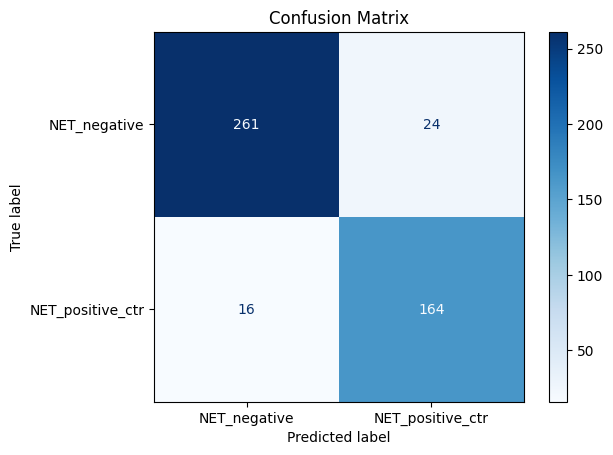

In [15]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib  # Import joblib to save the model

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = '../data/subimages_for_modeling/modeling_set_ctr'
MODEL_SAVE_PATH = '../models/logistic_regression_model_DOP.pkl'  # Path to save the model

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)

# Function to extract features and labels from the generator
def extract_features(generator):
    features = []
    labels = []
    batch_size = generator.batch_size
    
    num_batches = len(generator)
    for _ in range(num_batches):
        batch_features, batch_labels = next(generator)  # Use next(generator) to fetch the next batch
        batch_features = batch_features.reshape((batch_features.shape[0], -1))  # Flatten the images
        features.append(batch_features)
        labels.append(batch_labels)
        
    # Stack all batches together
    features = np.vstack(features)
    labels = np.vstack(labels)
    
    return features, np.argmax(labels, axis=1)


# Extract features and labels
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)
X_test, y_test = extract_features(test_generator)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Create a logistic regression model with a pipeline for standardization and PCA for dimensionality reduction
model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=100)),  # Reduce dimensionality to 100 components for faster training
    ('logistic', LogisticRegression(class_weight=class_weights, max_iter=1000))
])

# Train the model
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# Load the model (optional, for demonstration)
loaded_model = joblib.load(MODEL_SAVE_PATH)
print("Model loaded successfully")

# Evaluate the model
y_pred = loaded_model.predict(X_test)

# Calculate precision, recall, F1 score
report = classification_report(y_test, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Predicted class: NET_negative
Prediction probabilities: [[9.99864926e-01 1.35073870e-04]]


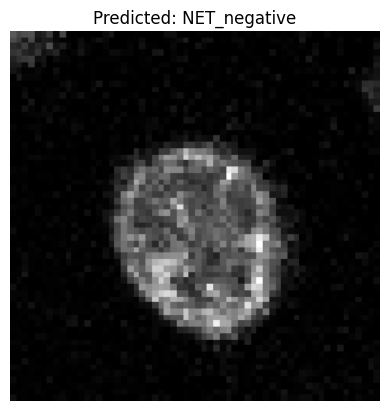

(0, array([[9.99864926e-01, 1.35073870e-04]]))

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


# Function to predict the class of a specific image and display it
def predict_and_display_image(image_path, model, img_size=IMG_SIZE):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, -1))  # Flatten the image
    img_array = img_array / 255.0  # Rescale the image

    # Make a prediction
    prediction_prob = model.predict_proba(img_array)
    predicted_class = np.argmax(prediction_prob, axis=1)[0]

    # Get the class labels
    class_labels = list(train_generator.class_indices.keys())

    # Print the results
    print(f"Predicted class: {class_labels[predicted_class]}")
    print(f"Prediction probabilities: {prediction_prob}")

    # Display the image
    plt.imshow(img_array.reshape(img_size), cmap='gray')
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.axis('off')
    plt.show()

    return predicted_class, prediction_prob

# Predict the class of a specific image from the test set
image_path = os.path.join(DATASET_PATH, test_generator.filenames[47])  # Change the index to test other images
predict_and_display_image(image_path, model)


Found 744 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Scaler saved to ../models/scaler.pkl
PCA saved to ../models/pca.pkl
Model saved to ../models/logistic_regression_model_DOP.pkl
Model loaded successfully
Classification Report:
                   precision    recall  f1-score   support

    NET_negative       0.94      0.92      0.93       285
NET_positive_ctr       0.87      0.91      0.89       180

        accuracy                           0.91       465
       macro avg       0.91      0.91      0.91       465
    weighted avg       0.91      0.91      0.91       465



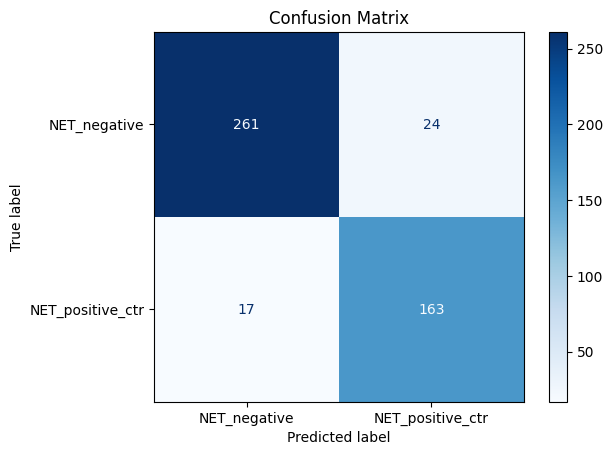

In [19]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib  # Import joblib to save the model

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = '../data/subimages_for_modeling/modeling_set_ctr'
MODEL_SAVE_PATH = '../models/logistic_regression_model_DOP.pkl'  # Path to save the model
SCALER_SAVE_PATH = '../models/scaler.pkl'
PCA_SAVE_PATH = '../models/pca.pkl'

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)

# Function to extract features and labels from the generator
def extract_features(generator):
    features = []
    labels = []
    batch_size = generator.batch_size
    
    num_batches = len(generator)
    for _ in range(num_batches):
        batch_features, batch_labels = next(generator)  # Use next(generator) to fetch the next batch
        batch_features = batch_features.reshape((batch_features.shape[0], -1))  # Flatten the images
        features.append(batch_features)
        labels.append(batch_labels)
        
    # Stack all batches together
    features = np.vstack(features)
    labels = np.vstack(labels)
    
    return features, np.argmax(labels, axis=1)


# Extract features and labels
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)
X_test, y_test = extract_features(test_generator)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Create and fit the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, SCALER_SAVE_PATH)
print(f"Scaler saved to {SCALER_SAVE_PATH}")

# Create and fit the PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
joblib.dump(pca, PCA_SAVE_PATH)
print(f"PCA saved to {PCA_SAVE_PATH}")

# Create a logistic regression model
model = LogisticRegression(class_weight=class_weights, max_iter=1000)

# Train the model
model.fit(X_train_pca, y_train)

# Save the trained model
joblib.dump(model, MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# Load the model (optional, for demonstration)
loaded_model = joblib.load(MODEL_SAVE_PATH)
print("Model loaded successfully")

# Evaluate the model
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
y_pred = loaded_model.predict(X_test_pca)

# Calculate precision, recall, F1 score
report = classification_report(y_test, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Found 744 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Found 465 images belonging to 2 classes.
Scaler saved to ../models/scaler_v2.pkl
PCA saved to ../models/pca_v2.pkl
Model saved to ../models/logistic_regression_model_DOP_v2.pkl
Model loaded successfully
Classification Report:
                   precision    recall  f1-score   support

    NET_negative       0.94      0.91      0.93       285
NET_positive_ctr       0.87      0.91      0.89       180

        accuracy                           0.91       465
       macro avg       0.90      0.91      0.91       465
    weighted avg       0.91      0.91      0.91       465



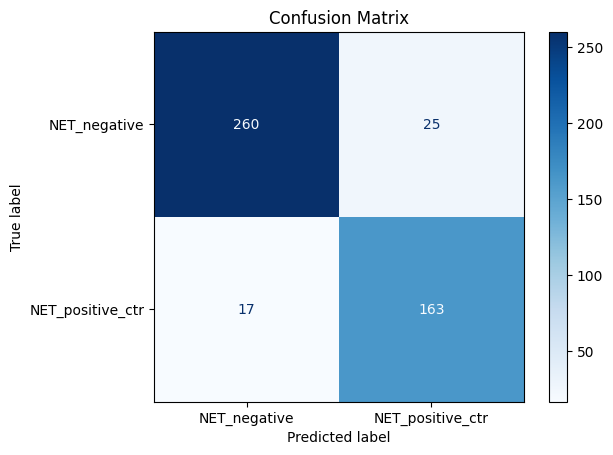

In [23]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = '../data/subimages_for_modeling/modeling_set_ctr'
MODEL_SAVE_PATH = '../models/logistic_regression_model_DOP_v2.pkl'  # Path to save the model
SCALER_SAVE_PATH = '../models/scaler_v2.pkl'
PCA_SAVE_PATH = '../models/pca_v2.pkl'

# Data generator with train-test split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)

# Further split validation set to create a test set
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale'  # Specify color mode here
)

test_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'  # Specify color mode here
)

# Function to extract features and labels from the generator
def extract_features(generator):
    features = []
    labels = []
    batch_size = generator.batch_size
    
    num_batches = len(generator)
    for _ in range(num_batches):
        batch_features, batch_labels = next(generator)  # Use next(generator) to fetch the next batch
        batch_features = batch_features.reshape((batch_features.shape[0], -1))  # Flatten the images
        features.append(batch_features)
        labels.append(batch_labels)
        
    # Stack all batches together
    features = np.vstack(features)
    labels = np.vstack(labels)
    
    return features, np.argmax(labels, axis=1)

# Extract features and labels
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)
X_test, y_test = extract_features(test_generator)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Create and fit the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, SCALER_SAVE_PATH)
print(f"Scaler saved to {SCALER_SAVE_PATH}")

# Create and fit the PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
joblib.dump(pca, PCA_SAVE_PATH)
print(f"PCA saved to {PCA_SAVE_PATH}")

# Create a logistic regression model with L2 regularization
model = LogisticRegression(class_weight=class_weights, max_iter=1000, penalty='l2', C=1.0)

# Train the model
model.fit(X_train_pca, y_train)

# Save the trained model
joblib.dump(model, MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

# Load the model (optional, for demonstration)
loaded_model = joblib.load(MODEL_SAVE_PATH)
print("Model loaded successfully")

# Evaluate the model
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
y_pred = loaded_model.predict(X_test_pca)

# Calculate precision, recall, F1 score
report = classification_report(y_test, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Predicted class: NET_positive_ctr
Prediction probabilities: [[0.27197705 0.72802295]]


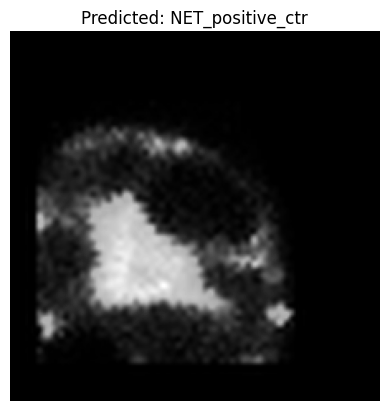

(1, array([[0.27197705, 0.72802295]]))

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


# Function to predict the class of a specific image and display it
def predict_and_display_image(image_path, model, img_size=IMG_SIZE):
    # Load and preprocess the image
    img = load_img(image_path, target_size=img_size, color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, -1))  # Flatten the image
    img_array = img_array / 255.0  # Rescale the image


    # Apply StandardScaler and PCA
    img_array_scaled = scaler.transform(img_array)
    img_array_pca = pca.transform(img_array_scaled)

    # Make a prediction
    prediction_prob = model.predict_proba(img_array_pca)
    predicted_class = np.argmax(prediction_prob, axis=1)[0]

    # Get the class labels
    class_labels = list(train_generator.class_indices.keys())

    # Print the results
    print(f"Predicted class: {class_labels[predicted_class]}")
    print(f"Prediction probabilities: {prediction_prob}")

    # Display the image
    plt.imshow(img_array.reshape(img_size), cmap='gray')
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.axis('off')
    plt.show()

    return predicted_class, prediction_prob

# Predict the class of a specific image from the test set
image_path = os.path.join(DATASET_PATH, test_generator.filenames[452])  # Change the index to test other images
predict_and_display_image(image_path, model)
